In [7]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn  as sns
warnings.filterwarnings("ignore")

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

# Modelling
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool

# Evaluation and Optimization
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Model Save
import pickle

In [8]:
df = pd.read_csv("car_acceptability.txt", sep = ",", header = None)
df.columns = ["buying", "maint", "doors", "persons", "lug_boot", "safety", "class"]
df.head()

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,?,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,?,unacc


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1729 entries, 0 to 1728
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   buying    1728 non-null   object
 1   maint     1729 non-null   object
 2   doors     1729 non-null   object
 3   persons   1729 non-null   object
 4   lug_boot  1729 non-null   object
 5   safety    1728 non-null   object
 6   class     1729 non-null   object
dtypes: object(7)
memory usage: 94.7+ KB


In [10]:
# Sütunlar üzerinde değerlerin dağılımı

for col in df:
    print(df[col].value_counts(), "\n")

buying
high     432
med      431
vhigh    430
low      430
?          3
-          1
düsük      1
Name: count, dtype: int64 

maint
high     432
med      432
low      432
vhigh    429
?          4
Name: count, dtype: int64 

doors
3        432
2        430
4        430
5more    430
?          3
-          1
44         1
iki        1
5+         1
Name: count, dtype: int64 

persons
4       576
more    576
2       574
?         3
Name: count, dtype: int64 

lug_boot
small    576
big      576
med      575
?          2
Name: count, dtype: int64 

safety
high    576
med     574
low     573
?         2
-         2
*         1
Name: count, dtype: int64 

class
unacc    1209
acc       384
good       69
vgood      65
?           2
Name: count, dtype: int64 



In [11]:
# Yanlış girilen metinleri null veya doğru haline çevirme

df.replace(["?", "-", "*"], np.nan, inplace = True)

df["buying"].replace("düsük", "low", inplace = True)
df["doors"].replace("44", "4", inplace = True)
df["doors"].replace("iki", "2", inplace = True)
df["doors"].replace("5+", "5more", inplace = True)

In [12]:
# Null değerlerin olduğu satırlar

filter_mask = df.isnull().any(axis = 1)

print(df[filter_mask])

     buying  maint  doors persons lug_boot safety  class
2     vhigh  vhigh      2     NaN    small   high  unacc
4     vhigh  vhigh      2       2      med    NaN  unacc
13    vhigh    NaN      2       4      med    med  unacc
21      NaN    NaN      2    more      NaN    low  unacc
61      NaN  vhigh    NaN       2      big    med    NaN
951     med    NaN  5more       2      big    low  unacc
968     med  vhigh    NaN    more      med   high    acc
975     med   high      2       2      med    NaN  unacc
993     NaN   high      2    more      med    low  unacc
1048    med   high      4    more      med    NaN    acc
1388    NaN  vhigh  5more       4    small   high    acc
1467    low   high      4       4    small    NaN  unacc
1518    low    med    NaN     NaN      big    low  unacc
1599    low    med  5more       2      big    NaN  unacc
1728    NaN    NaN    NaN     NaN      NaN    NaN    NaN


In [13]:
df.drop(1728, inplace = True)  # Tüm row null olduğundan bu datayı atıyorum, max. null sayısına sahip rowlar 3 den fazla null'u geçmiyor,
                               # 4-5 null var ise atmayı düşünüyordum fakat 6 özellikten 3 tanesi null olanları atma ihtiyacı duymadım.

In [14]:
# Null değerleri mod ile doldurma

imputer = SimpleImputer(missing_values = np.nan,
                        strategy ='most_frequent')

imputer = imputer.fit(df)
new_df = imputer.transform(df)
new_df = pd.DataFrame(new_df, columns = df.columns)
df = new_df

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   buying    1728 non-null   object
 1   maint     1728 non-null   object
 2   doors     1728 non-null   object
 3   persons   1728 non-null   object
 4   lug_boot  1728 non-null   object
 5   safety    1728 non-null   object
 6   class     1728 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB


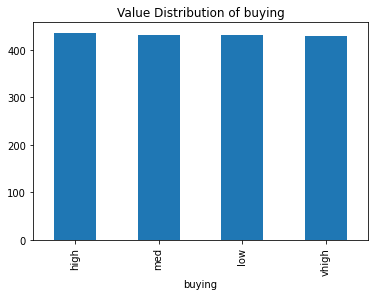

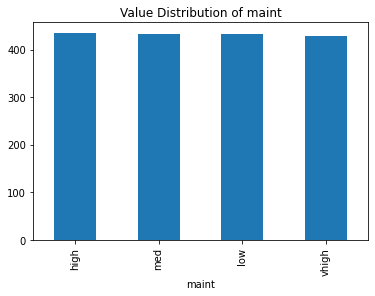

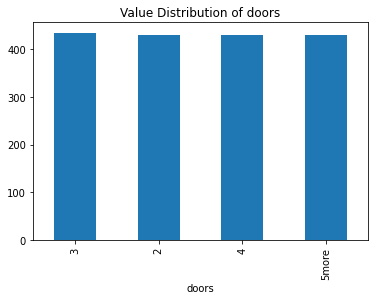

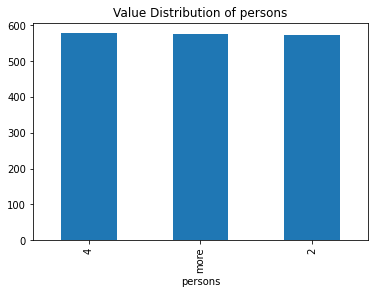

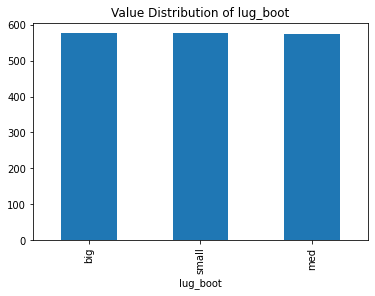

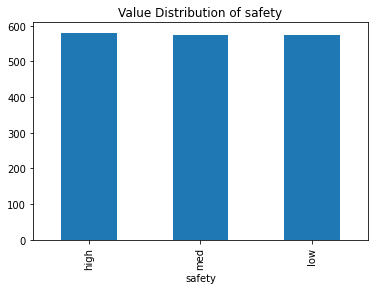

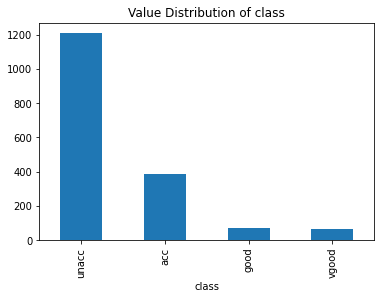

In [15]:
# Veriyi düzenledikten sonra sütunlarda değer dağılımı

for col in df:
    df[col].value_counts().plot(kind = "bar")
    plt.title(f"Value Distribution of {col}")
    plt.show()

Verimizde tüm sütunlarda normal bir dağılım gözlemlenirken target sütunumuzda "unacc" değeri, diğer değerlere oranla daha fazla bulunmakta.
Target sütunumuz dengesiz bir dağılıma sahip

In [16]:
# target sütunu encode etme işlemi
# Burada OrdinalEncoder kullanmama sebebim, unacc'den vgood'a doğru giderken arabanın daha üstün/uygun olması, bu yüzden onlara daha büyük bir ağırlık vermek istedim.

y_encoder_dict = {
    "unacc": "0",
    "acc": "1",
    "good": "2",
    "vgood": "3"
}

df["class"] = df["class"].map(y_encoder_dict)
df["class"] = df["class"].astype("int64")

In [17]:
X = df.drop("class", axis = 1)
y = df["class"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y)

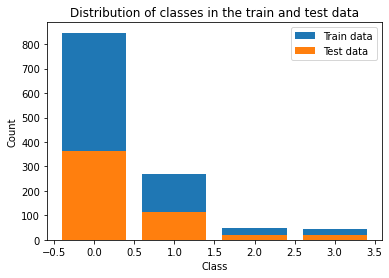

In [18]:
plt.bar(y_train.value_counts().index, y_train.value_counts(), label = "Train data")
plt.bar(y_test.value_counts().index, y_test.value_counts(), label = "Test data")
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Distribution of classes in the train and test data")
plt.legend()

### Modelling

In [19]:
# Model Evaluation için genel metrikleri gösterecek fonksiyon

def analyze_results(y_test, y_pred):
    print(f"Accuracy Score: {round(accuracy_score(y_test, y_pred), 3)}\n")
    print(classification_report(y_test, y_pred, digits = 3))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot = True)
    plt.xlabel("Actual")
    plt.ylabel("Prediction")

#### Tuned CatBoost

In [30]:
train_pool = Pool(X_train, y_train, cat_features = list(X_train.select_dtypes(include = "object").columns))

In [36]:
cat_model = CatBoostClassifier(task_type = "GPU")

cat_param_dist = {
    'iterations': [100, 300, 500],
    'learning_rate': [0.01, 0.03, 0.1],
    "depth": [3, 5, 7, 10],
    'l2_leaf_reg': [1, 3, 5],
}

search_results = cat_model.randomized_search(
    cat_param_dist, 
    train_pool,
    n_iter = 20
)

0:	learn: 1.3449787	test: 1.3495212	best: 1.3495212 (0)	total: 7.9ms	remaining: 782ms
1:	learn: 1.3074450	test: 1.3160117	best: 1.3160117 (1)	total: 17.8ms	remaining: 871ms
2:	learn: 1.2731277	test: 1.2852940	best: 1.2852940 (2)	total: 24.7ms	remaining: 797ms
3:	learn: 1.2415837	test: 1.2569960	best: 1.2569960 (3)	total: 31ms	remaining: 743ms
4:	learn: 1.2124580	test: 1.2308183	best: 1.2308183 (4)	total: 38ms	remaining: 722ms
5:	learn: 1.1854618	test: 1.2065155	best: 1.2065155 (5)	total: 44.2ms	remaining: 692ms
6:	learn: 1.1603560	test: 1.1838842	best: 1.1838842 (6)	total: 50.4ms	remaining: 670ms
7:	learn: 1.1369407	test: 1.1627525	best: 1.1627525 (7)	total: 56.8ms	remaining: 653ms
8:	learn: 1.1150458	test: 1.1429741	best: 1.1429741 (8)	total: 63.3ms	remaining: 640ms
9:	learn: 1.0945264	test: 1.1244242	best: 1.1244242 (9)	total: 69.8ms	remaining: 628ms
10:	learn: 1.0752574	test: 1.1069934	best: 1.1069934 (10)	total: 76.2ms	remaining: 617ms
11:	learn: 1.0571295	test: 1.0905870	best: 1.0

In [37]:
search_results["params"]

{'depth': 5, 'l2_leaf_reg': 1, 'iterations': 300, 'learning_rate': 0.1}

In [38]:
cat_model = CatBoostClassifier(
    task_type = "GPU",
    iterations = 300,
    depth = 5,
    l2_leaf_reg = 1,
    learning_rate = 0.1,
    verbose = 0
)

cat_model.fit(train_pool)
cat_preds = cat_model.predict(X_test)

Accuracy Score: 0.944

              precision    recall  f1-score   support

           0      0.989     0.983     0.986       363
           1      0.868     0.913     0.890       115
           2      0.812     0.619     0.703        21
           3      0.714     0.750     0.732        20

    accuracy                          0.944       519
   macro avg      0.846     0.816     0.828       519
weighted avg      0.944     0.944     0.944       519



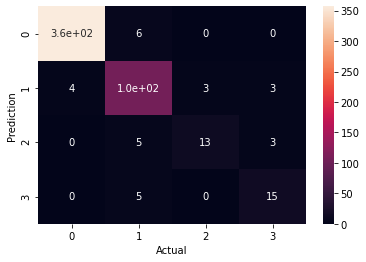

In [39]:
analyze_results(y_test, cat_preds)

# İlk önce class sütununu encode etmeden direkt catboost'a verdim (notebook'da bu kısma yer vermedim), ondan sonrasında ise encode ederek verdim.
# encode edilmiş haliyle daha başarılı sonuç verdi.

### Other Models

In [21]:
# CatBoost'da Pool fonksiyonu sayesinde encode etmemize ihtiyaç yoktu, diğer modeller için ise var

encoder = OrdinalEncoder()
encoder = OrdinalEncoder(handle_unknown = "use_encoded_value", unknown_value = -1)

X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

#### XGBoost

Accuracy Score: 0.985

              precision    recall  f1-score   support

           0      0.992     0.997     0.995       363
           1      0.957     0.974     0.966       115
           2      1.000     0.810     0.895        21
           3      1.000     1.000     1.000        20

    accuracy                          0.985       519
   macro avg      0.987     0.945     0.964       519
weighted avg      0.985     0.985     0.984       519



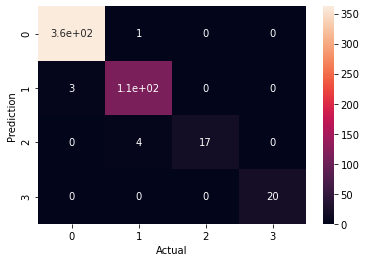

In [43]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

xgb_preds = xgb.predict(X_test)

analyze_results(y_test, xgb_preds)

#### Tuned XGBoost

In [44]:
base_xgb = XGBClassifier()

param_dist = {
    'n_estimators': np.arange(100, 2000, 100),
    'max_depth' : np.arange(2, 12, 1),
    'learning_rate': np.arange(0.01, 1, 0.05),
    "subsample": [0.5, 0.6, 0.7, 0.8, 0.9, 1] # Her seferinde verisetinin % kaçını kullansın
}

random_model = RandomizedSearchCV(base_xgb, param_distributions = param_dist, n_iter = 20, cv = 5, scoring = "f1_weighted", verbose = 0)
# Target column normal bir dağılıma sahip olmadığı için scoring'de ağırlıklı f1 kullanmayı tercih ettim
random_model.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None,...
                   param_distributions={'learning_rate': array([0.01, 0.06, 0.11, 0.16, 0.21, 0.26, 0.31, 0.36, 0.41, 0.46, 0.51,
       0.56, 0.61, 0.66, 0.71, 0.76, 0.81, 0.86, 0.91, 0.96]),
                                        'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
                                        'n_estimators': array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000, 1100,
       1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900]),
                                        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9,
                                                      1]},
                   scoring='f1_weighted')

Accuracy Score: 0.99

              precision    recall  f1-score   support

           0      0.997     1.000     0.999       363
           1      0.966     0.991     0.979       115
           2      1.000     0.810     0.895        21
           3      1.000     1.000     1.000        20

    accuracy                          0.990       519
   macro avg      0.991     0.950     0.968       519
weighted avg      0.991     0.990     0.990       519



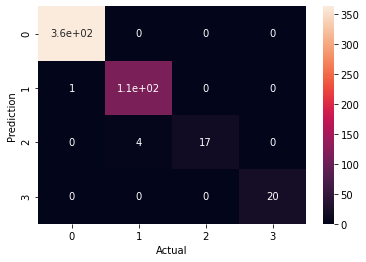

In [45]:
xgb_tuned = random_model.best_estimator_
xgb_tuned_pred = xgb_tuned.predict(X_test)

analyze_results(y_test, xgb_tuned_pred)

#### Logistic Regression

Accuracy Score: 0.707

              precision    recall  f1-score   support

           0      0.750     0.950     0.838       363
           1      0.425     0.148     0.219       115
           2      0.000     0.000     0.000        21
           3      0.263     0.250     0.256        20

    accuracy                          0.707       519
   macro avg      0.360     0.337     0.329       519
weighted avg      0.629     0.707     0.645       519



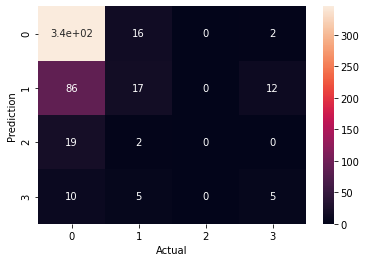

In [46]:
reg = LogisticRegression()
reg.fit(X_train, y_train)
reg_preds = reg.predict(X_test)

analyze_results(y_test, reg_preds)

#### Random Forest

Accuracy Score: 0.963

              precision    recall  f1-score   support

           0      0.984     0.989     0.986       363
           1      0.930     0.922     0.926       115
           2      1.000     0.714     0.833        21
           3      0.800     1.000     0.889        20

    accuracy                          0.963       519
   macro avg      0.928     0.906     0.909       519
weighted avg      0.965     0.963     0.963       519



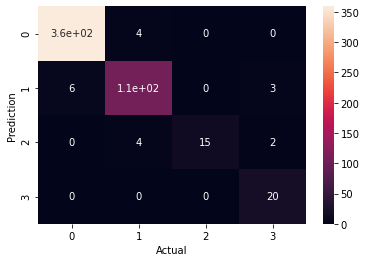

In [49]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

analyze_results(y_test, rf_preds)

#### LightGBM

Accuracy Score: 0.99

              precision    recall  f1-score   support

           0      1.000     0.994     0.997       363
           1      0.958     1.000     0.979       115
           2      1.000     0.857     0.923        21
           3      1.000     1.000     1.000        20

    accuracy                          0.990       519
   macro avg      0.990     0.963     0.975       519
weighted avg      0.991     0.990     0.990       519



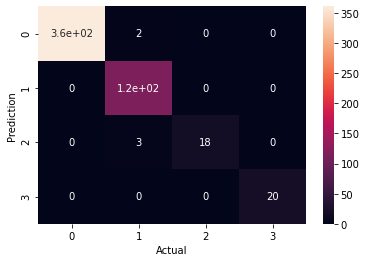

In [24]:
lgbm = LGBMClassifier(verbose = -1)
lgbm.fit(X_train, y_train)
lgbm_preds = lgbm.predict(X_test)

analyze_results(y_test, lgbm_preds)

In [31]:
base_lgbm = LGBMClassifier(verbose = -1)

param_dist = {
    'n_estimators': np.arange(100, 2000, 100),
    'max_depth' : np.arange(2, 12, 1),
    'learning_rate': np.arange(0.01, 1, 0.05),
    "subsample": [0.5, 0.6, 0.7, 0.8, 0.9, 1]
}

random_model = RandomizedSearchCV(base_lgbm, param_distributions = param_dist, n_iter = 20, cv = 5, scoring = "f1_weighted", verbose = 0)
# Target column normal bir dağılıma sahip olmadığı için scoring'de ağırlıklı f1 kullanmayı tercih ettim
random_model.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=LGBMClassifier(verbose=-1), n_iter=20,
                   param_distributions={'learning_rate': array([0.01, 0.06, 0.11, 0.16, 0.21, 0.26, 0.31, 0.36, 0.41, 0.46, 0.51,
       0.56, 0.61, 0.66, 0.71, 0.76, 0.81, 0.86, 0.91, 0.96]),
                                        'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
                                        'n_estimators': array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000, 1100,
       1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900]),
                                        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9,
                                                      1]},
                   scoring='f1_weighted')

In [32]:
random_model.best_params_

{'subsample': 1,
 'n_estimators': 1600,
 'max_depth': 4,
 'learning_rate': 0.7100000000000001}

Accuracy Score: 0.992

              precision    recall  f1-score   support

           0      1.000     0.997     0.999       363
           1      0.966     1.000     0.983       115
           2      1.000     0.857     0.923        21
           3      1.000     1.000     1.000        20

    accuracy                          0.992       519
   macro avg      0.992     0.964     0.976       519
weighted avg      0.993     0.992     0.992       519



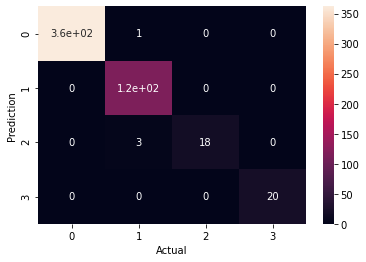

In [33]:
lgbm_tuned = random_model.best_estimator_
lgbm_tuned_pred = lgbm_tuned.predict(X_test)

analyze_results(y_test, lgbm_tuned_pred)

### Conclusion

En iyi modeller olan Tuned XGBoost ve TunedLightGBM'ı karşılaştırdığımızda ufak bir fark ile öne geçiyor.
Tuned LightGBM, Class 2'leri, yani 'good' class'ları, XGBoost'a göre daha iyi tahmin ettiğinden ve XGBoost'dan daha hızlı bir model olduğundan son model olarak Tuned LightGBM'i seçiyorum.

In [34]:
X = encoder.fit_transform(X)

final_lightgbm_model = random_model.best_estimator_
final_lightgbm_model.fit(X, y)

LGBMClassifier(learning_rate=0.7100000000000001, max_depth=4, n_estimators=1600,
               subsample=1, verbose=-1)

In [36]:
# Modelimizi mevcut dizine kaydediyoruz

pickle.dump(final_lightgbm_model, open('tuned_lightgbm_acc99.pkl', 'wb'))